In [1]:
#Imporing libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# ==============================================================================================================
# [26 Mei 2020]: ditambahkan agar angka random selalu sama ketika program dijalankan, sehingga hasil selalu sama
# ==============================================================================================================
np.random.seed(1234)
torch.manual_seed(1234)
# ==============================================================================================================

In [2]:
#Reading data
learn_data = pd.read_csv("bigml_59c28831336c6604c800002a.csv")
pd.options.display.max_columns = None
learn_data

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [3]:
#Defining columns
numerical_columns = ['account length', 'area code', 'number vmail messages', 'total day minutes', 'total day calls',
                     'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes',
                     'total night calls', 'total night charge', 'total intl minutes', 'total intl calls',
                     'total intl charge', 'customer service calls']
categorical_columns = ['state', 'international plan', 'voice mail plan']
outputs = ['churn']

In [4]:
#Processing columns

#Numerical
numerical_data = np.stack([learn_data[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)

#Categorical
for category in categorical_columns:
    learn_data[category] = learn_data[category].astype('category')
    
st = learn_data['state'].cat.codes.values
ip = learn_data['international plan'].cat.codes.values
vm = learn_data['voice mail plan'].cat.codes.values

categorical_data = np.stack([st, ip, vm], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

#Outputs
learn_data[outputs] = learn_data[outputs].astype(int)

outputs = torch.tensor(learn_data[outputs].values).flatten()
outputs = outputs.long()

In [5]:
#Dividing the data
total_records = 3333
train_records = int(total_records * .6)
valid_records = int(total_records * .2)
test_records = int(total_records * .2)
numerical_train_data = numerical_data[:train_records]
numerical_valid_data = numerical_data[train_records:train_records+valid_records]
numerical_test_data = numerical_data[train_records+valid_records:total_records]
categorical_train_data = categorical_data[:train_records]
categorical_valid_data = categorical_data[train_records:train_records+valid_records]
categorical_test_data = categorical_data[train_records+valid_records:total_records]
train_outputs = outputs[:train_records]
valid_outputs = outputs[train_records:train_records+valid_records]
test_outputs = outputs[train_records+valid_records:total_records]

In [6]:
from torch.nn.parameter import Parameter
from torch.nn import init
import math

#Creating the Neural Network
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(16, 100)
        self.act1 = nn.ReLU(inplace=True)
        
        # =============================================================================================
        # [26 Mei 2020]:
        # weights1 dan 2 diubah menggunakan Parameter agar sesuai konvensi yang digunakan oleh nn.Linear
        # (https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear)
        # 
        # weight dan bias dirandom menggunakan formula Kaiming initialization, 
        # pertama kali diperkenalkan di paper berikut:
        # http://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html
        # 
        # perubahan ini diperlukan karena implementasi yang sebelumnya tidak memberikan hasil sebaik 
        # layer linear biasa
        #
        # layer2 dihapus
        # =============================================================================================
        self.weights1 = Parameter(torch.Tensor(1, 115))
        init.kaiming_uniform_(self.weights1, a=math.sqrt(5))
        
        self.weights2 = Parameter(torch.Tensor(1, 115)) #2 karena mewakili output true/false churn ❓❔
        init.kaiming_uniform_(self.weights2, a=math.sqrt(5))
        
        self.bias1 = Parameter(torch.Tensor(1))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weights1)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias1, -bound, bound)
        
        self.bias2 = Parameter(torch.Tensor(1))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weights2)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias2, -bound, bound)
        # =============================================================================================
        
        self.layer1_1 = nn.Embedding(51, 5)
        self.layer1_2 = nn.Embedding(2, 5)
        self.layer1_3 = nn.Embedding(2, 5)
        
    def forward(self, x_numerical, x_categorical):
        x1 = self.layer1(x_numerical)
        
        x1_embedding = self.layer1_1(x_categorical[:,0])
        x2_embedding = self.layer1_2(x_categorical[:,1])
        x3_embedding = self.layer1_3(x_categorical[:,2])
        x_embedding = torch.cat([x1_embedding,x2_embedding,x3_embedding], 1)
        
        x1_1 = torch.cat([x1, x_embedding], 1)
        
        x1_act = self.act1(x1_1)
        
        # =============================================================================================
        # [26 Mei 2020]: ditambahkan bias, layer2 dihapus
        # =============================================================================================
        x1_weights1 = torch.mm(x1_act, self.weights1.t()) + self.bias1 #apa ini dihitungnya disini 🤔
        x1_weights2 = torch.mm(x1_act, self.weights2.t()) + self.bias2
        
        x2 = torch.cat([x1_weights1, x1_weights2], 1)
        # =============================================================================================
                
        return x1_act, self.weights1, self.weights2, x2

In [7]:
model = Model()

In [8]:
# =============================================================================================
# [26 Mei 2020]: 
# cross entropy loss ditambahkan parameter weight, karena ternyata data imbalance (data not churn
# jauh lebih banyak dari churn, dengan rasio sekitar 85:15). Data imbalance ini menyebabkan hasil 
# prediksi untuk kelas churn tidak baik. Solusinya adalah dengan menggunakan parameter weight di
# cross entropy loss, sehingga penalty untuk salah di kelas churn jauh lebih besar daripada salah
# di kelas not churn. Penalty diperbesar dengan rasio kebalikan dari rasio jumlah datanya (15:85)
# =============================================================================================

churn_percentage = 0.85
#Defining loss function
loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1-churn_percentage, churn_percentage]))
# loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
#Training the data
epochs = 100 #JUMLAH BERAPA KALI DATASET DIGUNAKAN UNTUK TRAIN MODEL
batch_size = 10
mean_losses_train = []
mean_losses_valid = []
best_loss_valid = np.inf

for i in range(epochs):
    aggregated_losses_train = []
    aggregated_losses_valid = []
    i += 1
    for j in range((train_records//batch_size)+1):
        start_train = j*batch_size
        end_train = start_train+10
        train, weights1, weights2, train_embed = model(numerical_train_data[start_train:end_train], categorical_train_data[start_train:end_train]) # yg error 1
        train_loss = loss_function(train_embed, train_outputs[start_train:end_train])
        aggregated_losses_train.append(train_loss)

        print(f'iteration: {j:3} loss: {train_loss.item():10.8f}')

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        mean_loss_train = torch.mean(torch.stack(aggregated_losses_train))
        
    print(f'epoch: {i:3} mean loss training: {mean_loss_train.item():10.8f}')
    mean_losses_train.append(mean_loss_train)
    
    with torch.set_grad_enabled(False):
        for k in range((valid_records//batch_size)+1):
            start_valid = k*batch_size
            end_valid = start_valid+batch_size
            valid, weights1, weights2, valid_embed = model(numerical_valid_data[start_valid:end_valid], categorical_valid_data[start_valid:end_valid]) # kenapa disini harus ada 2 variabel prefix
            valid_loss = loss_function(valid_embed, valid_outputs[start_valid:end_valid])
            aggregated_losses_valid.append(valid_loss)
    mean_loss_valid = torch.mean(torch.stack(aggregated_losses_valid))
    print(f'epoch: {i:3} mean loss validation: {mean_loss_valid:.8f}')
    
    # =============================================================================================
    # [26 Mei 2020]: model disimpan ketika loss terrendah, bukan di epoch akhir
    # =============================================================================================
    if mean_loss_valid.cpu().numpy()[()] < best_loss_valid:
        best_loss_valid = mean_loss_valid
        torch.save(model.state_dict(), "model_train_cre.pth")
    # =============================================================================================
        
    
    mean_losses_valid.append(mean_loss_valid)

iteration:   0 loss: 58.69820786
iteration:   1 loss: 14.47583771
iteration:   2 loss: 15.02840328
iteration:   3 loss: 9.37973309
iteration:   4 loss: 6.42866230
iteration:   5 loss: 4.68631983
iteration:   6 loss: 9.64456654
iteration:   7 loss: 6.72116995
iteration:   8 loss: 11.68376446
iteration:   9 loss: 8.40734386
iteration:  10 loss: 0.02153537
iteration:  11 loss: 5.26507092
iteration:  12 loss: 3.70710206
iteration:  13 loss: 8.63516808
iteration:  14 loss: 4.35087204
iteration:  15 loss: 5.13799477
iteration:  16 loss: 6.26780939
iteration:  17 loss: 2.12859964
iteration:  18 loss: 5.78463650
iteration:  19 loss: 5.03421783
iteration:  20 loss: 0.01405343
iteration:  21 loss: 14.35758305
iteration:  22 loss: 0.00295033
iteration:  23 loss: 5.92754841
iteration:  24 loss: 2.05112243
iteration:  25 loss: 2.48751950
iteration:  26 loss: 0.53834456
iteration:  27 loss: 0.64577371
iteration:  28 loss: 1.67654109
iteration:  29 loss: 1.56392550
iteration:  30 loss: 3.53953314
ite

iteration:  94 loss: 1.11785495
iteration:  95 loss: 0.50952011
iteration:  96 loss: 1.39139867
iteration:  97 loss: 0.61636311
iteration:  98 loss: 0.29677215
iteration:  99 loss: 0.91561723
iteration: 100 loss: 0.60504580
iteration: 101 loss: 0.27483627
iteration: 102 loss: 1.08625209
iteration: 103 loss: 1.98364997
iteration: 104 loss: 0.47318402
iteration: 105 loss: 0.36202449
iteration: 106 loss: 0.33752173
iteration: 107 loss: 0.73509693
iteration: 108 loss: 0.33901811
iteration: 109 loss: 0.07969752
iteration: 110 loss: 2.62537074
iteration: 111 loss: 1.66786253
iteration: 112 loss: 1.39869595
iteration: 113 loss: 0.67663574
iteration: 114 loss: 1.80551457
iteration: 115 loss: 1.07166064
iteration: 116 loss: 3.00300431
iteration: 117 loss: 0.80985463
iteration: 118 loss: 0.95488989
iteration: 119 loss: 3.32399797
iteration: 120 loss: 2.41156173
iteration: 121 loss: 0.00270376
iteration: 122 loss: 0.00065497
iteration: 123 loss: 2.67167163
iteration: 124 loss: 2.34652185
iteratio

iteration: 195 loss: 1.03560293
iteration: 196 loss: 1.73074937
iteration: 197 loss: 4.21582222
iteration: 198 loss: 0.88945150
iteration: 199 loss: 0.00559849
epoch:   3 mean loss training: 1.37071466
epoch:   3 mean loss validation: 2.42267156
iteration:   0 loss: 0.00366686
iteration:   1 loss: 2.58058596
iteration:   2 loss: 2.44772458
iteration:   3 loss: 1.10316372
iteration:   4 loss: 1.05662560
iteration:   5 loss: 1.35398090
iteration:   6 loss: 2.79795933
iteration:   7 loss: 2.33359408
iteration:   8 loss: 1.54800296
iteration:   9 loss: 1.46402395
iteration:  10 loss: 2.75052404
iteration:  11 loss: 0.94395304
iteration:  12 loss: 2.43146968
iteration:  13 loss: 0.09250332
iteration:  14 loss: 2.84025240
iteration:  15 loss: 0.07288628
iteration:  16 loss: 0.01760115
iteration:  17 loss: 0.02670684
iteration:  18 loss: 1.26858449
iteration:  19 loss: 2.86406374
iteration:  20 loss: 0.09097333
iteration:  21 loss: 0.52988821
iteration:  22 loss: 1.83529949
iteration:  23 los

iteration:  92 loss: 0.29981306
iteration:  93 loss: 0.67807811
iteration:  94 loss: 0.63073170
iteration:  95 loss: 0.70019746
iteration:  96 loss: 0.89605576
iteration:  97 loss: 0.64978945
iteration:  98 loss: 0.15764502
iteration:  99 loss: 0.34766439
iteration: 100 loss: 0.57697916
iteration: 101 loss: 0.28524140
iteration: 102 loss: 0.75219584
iteration: 103 loss: 1.11410069
iteration: 104 loss: 0.51813978
iteration: 105 loss: 0.37554550
iteration: 106 loss: 0.15798752
iteration: 107 loss: 0.74207652
iteration: 108 loss: 0.39037433
iteration: 109 loss: 0.06613719
iteration: 110 loss: 2.63647008
iteration: 111 loss: 1.58144736
iteration: 112 loss: 1.30902910
iteration: 113 loss: 0.53129405
iteration: 114 loss: 1.34629476
iteration: 115 loss: 0.78620654
iteration: 116 loss: 2.69022703
iteration: 117 loss: 0.98501498
iteration: 118 loss: 0.13898088
iteration: 119 loss: 2.44103122
iteration: 120 loss: 1.91521299
iteration: 121 loss: 0.00123630
iteration: 122 loss: 0.00014401
iteratio

iteration: 197 loss: 2.94907713
iteration: 198 loss: 0.21074268
iteration: 199 loss: 0.10147348
epoch:   6 mean loss training: 1.02115715
epoch:   6 mean loss validation: 0.76953477
iteration:   0 loss: 0.16230711
iteration:   1 loss: 0.73145109
iteration:   2 loss: 0.54940599
iteration:   3 loss: 0.23360051
iteration:   4 loss: 0.60878968
iteration:   5 loss: 1.14307487
iteration:   6 loss: 1.46748793
iteration:   7 loss: 0.67141825
iteration:   8 loss: 0.41692531
iteration:   9 loss: 1.03855729
iteration:  10 loss: 0.21121499
iteration:  11 loss: 0.92250425
iteration:  12 loss: 1.13332629
iteration:  13 loss: 0.94822359
iteration:  14 loss: 1.07318532
iteration:  15 loss: 0.27787971
iteration:  16 loss: 0.23308359
iteration:  17 loss: 0.18285747
iteration:  18 loss: 0.21114594
iteration:  19 loss: 2.40520644
iteration:  20 loss: 0.02900133
iteration:  21 loss: 1.21947598
iteration:  22 loss: 0.27819112
iteration:  23 loss: 0.39824685
iteration:  24 loss: 0.70325148
iteration:  25 los

iteration: 108 loss: 0.73096871
iteration: 109 loss: 0.11919221
iteration: 110 loss: 1.89069891
iteration: 111 loss: 1.37224936
iteration: 112 loss: 1.10875154
iteration: 113 loss: 0.44184643
iteration: 114 loss: 0.99341226
iteration: 115 loss: 0.57061887
iteration: 116 loss: 2.28152013
iteration: 117 loss: 0.67839563
iteration: 118 loss: 0.32214096
iteration: 119 loss: 1.34026408
iteration: 120 loss: 1.27323437
iteration: 121 loss: 0.00291972
iteration: 122 loss: 0.00086313
iteration: 123 loss: 3.54916239
iteration: 124 loss: 2.17936492
iteration: 125 loss: 1.83141243
iteration: 126 loss: 1.22958636
iteration: 127 loss: 0.91191965
iteration: 128 loss: 2.17409277
iteration: 129 loss: 3.77171326
iteration: 130 loss: 2.68015146
iteration: 131 loss: 2.95150876
iteration: 132 loss: 0.84902620
iteration: 133 loss: 0.49861771
iteration: 134 loss: 0.58534563
iteration: 135 loss: 1.54001129
iteration: 136 loss: 1.00886333
iteration: 137 loss: 1.38660562
iteration: 138 loss: 0.22759353
iteratio

iteration:   0 loss: 0.50355428
iteration:   1 loss: 0.54225910
iteration:   2 loss: 0.41870070
iteration:   3 loss: 0.25343955
iteration:   4 loss: 0.56458181
iteration:   5 loss: 1.21355748
iteration:   6 loss: 0.91790497
iteration:   7 loss: 0.46530697
iteration:   8 loss: 0.44783327
iteration:   9 loss: 0.93272376
iteration:  10 loss: 0.46746251
iteration:  11 loss: 0.53175449
iteration:  12 loss: 0.94176036
iteration:  13 loss: 0.66776550
iteration:  14 loss: 0.86217093
iteration:  15 loss: 0.11503649
iteration:  16 loss: 0.07541829
iteration:  17 loss: 0.11212879
iteration:  18 loss: 0.15275168
iteration:  19 loss: 2.13103342
iteration:  20 loss: 0.06749504
iteration:  21 loss: 0.56633842
iteration:  22 loss: 0.43969741
iteration:  23 loss: 0.38213408
iteration:  24 loss: 0.38220602
iteration:  25 loss: 1.11834669
iteration:  26 loss: 0.90757722
iteration:  27 loss: 1.42517829
iteration:  28 loss: 0.66988850
iteration:  29 loss: 0.56797582
iteration:  30 loss: 0.37514484
iteratio

iteration:  75 loss: 0.78240025
iteration:  76 loss: 0.53401363
iteration:  77 loss: 0.59874624
iteration:  78 loss: 0.46871504
iteration:  79 loss: 0.73605651
iteration:  80 loss: 0.17612597
iteration:  81 loss: 0.13133688
iteration:  82 loss: 0.02396406
iteration:  83 loss: 0.98658699
iteration:  84 loss: 2.17951989
iteration:  85 loss: 0.41874337
iteration:  86 loss: 0.22498703
iteration:  87 loss: 0.47321004
iteration:  88 loss: 0.54726118
iteration:  89 loss: 0.55266690
iteration:  90 loss: 0.51265049
iteration:  91 loss: 0.37826288
iteration:  92 loss: 0.44139722
iteration:  93 loss: 0.46652618
iteration:  94 loss: 0.53945714
iteration:  95 loss: 0.19815150
iteration:  96 loss: 1.65480804
iteration:  97 loss: 0.80176914
iteration:  98 loss: 0.18455003
iteration:  99 loss: 0.55833554
iteration: 100 loss: 0.50236076
iteration: 101 loss: 0.25069618
iteration: 102 loss: 0.56652415
iteration: 103 loss: 1.02034724
iteration: 104 loss: 0.14335881
iteration: 105 loss: 0.22458209
iteratio

iteration: 187 loss: 0.10169895
iteration: 188 loss: 0.87596112
iteration: 189 loss: 0.30930170
iteration: 190 loss: 0.76981807
iteration: 191 loss: 1.20753551
iteration: 192 loss: 3.35245371
iteration: 193 loss: 0.18703665
iteration: 194 loss: 0.12977350
iteration: 195 loss: 2.31033897
iteration: 196 loss: 2.18451452
iteration: 197 loss: 1.25656295
iteration: 198 loss: 0.06902838
iteration: 199 loss: 0.29248038
epoch:  12 mean loss training: 0.80118299
epoch:  12 mean loss validation: 0.49077326
iteration:   0 loss: 0.69005752
iteration:   1 loss: 0.46617064
iteration:   2 loss: 0.31780970
iteration:   3 loss: 0.23132950
iteration:   4 loss: 0.59638333
iteration:   5 loss: 1.20470679
iteration:   6 loss: 0.57269871
iteration:   7 loss: 0.36597225
iteration:   8 loss: 0.48420557
iteration:   9 loss: 1.01253653
iteration:  10 loss: 0.83659518
iteration:  11 loss: 0.40370414
iteration:  12 loss: 0.61348295
iteration:  13 loss: 0.53857630
iteration:  14 loss: 0.83376950
iteration:  15 los

iteration:  91 loss: 0.48110867
iteration:  92 loss: 0.90125465
iteration:  93 loss: 0.52516240
iteration:  94 loss: 0.49940208
iteration:  95 loss: 0.14733210
iteration:  96 loss: 2.32377529
iteration:  97 loss: 1.24054420
iteration:  98 loss: 0.08240974
iteration:  99 loss: 0.15372479
iteration: 100 loss: 0.40118462
iteration: 101 loss: 0.27419236
iteration: 102 loss: 0.62682360
iteration: 103 loss: 0.81416076
iteration: 104 loss: 0.39529926
iteration: 105 loss: 0.26645926
iteration: 106 loss: 0.05775397
iteration: 107 loss: 0.98818552
iteration: 108 loss: 0.15395159
iteration: 109 loss: 0.01405705
iteration: 110 loss: 2.38127375
iteration: 111 loss: 1.58084297
iteration: 112 loss: 1.38175380
iteration: 113 loss: 0.38273400
iteration: 114 loss: 1.01471174
iteration: 115 loss: 0.70233476
iteration: 116 loss: 3.35467482
iteration: 117 loss: 1.45963538
iteration: 118 loss: 0.11147616
iteration: 119 loss: 0.43274656
iteration: 120 loss: 0.67224222
iteration: 121 loss: 0.00082454
iteratio

iteration: 145 loss: 0.59792817
iteration: 146 loss: 0.37306771
iteration: 147 loss: 1.15332401
iteration: 148 loss: 1.21092439
iteration: 149 loss: 1.08542037
iteration: 150 loss: 1.85941422
iteration: 151 loss: 0.50443089
iteration: 152 loss: 1.77902842
iteration: 153 loss: 3.23610210
iteration: 154 loss: 0.03473057
iteration: 155 loss: 2.35809469
iteration: 156 loss: 0.03803581
iteration: 157 loss: 0.46186903
iteration: 158 loss: 0.36896652
iteration: 159 loss: 0.36579913
iteration: 160 loss: 0.33431065
iteration: 161 loss: 0.73760408
iteration: 162 loss: 0.05072192
iteration: 163 loss: 0.75157708
iteration: 164 loss: 1.61231816
iteration: 165 loss: 0.71357608
iteration: 166 loss: 0.29821673
iteration: 167 loss: 0.23391460
iteration: 168 loss: 1.65021372
iteration: 169 loss: 0.33785596
iteration: 170 loss: 0.76869524
iteration: 171 loss: 0.29533699
iteration: 172 loss: 0.18914129
iteration: 173 loss: 0.35661319
iteration: 174 loss: 1.54223490
iteration: 175 loss: 1.62404001
iteratio

iteration:  53 loss: 0.34964550
iteration:  54 loss: 0.07816915
iteration:  55 loss: 0.50051922
iteration:  56 loss: 0.30812207
iteration:  57 loss: 0.50076133
iteration:  58 loss: 1.12348056
iteration:  59 loss: 0.56612319
iteration:  60 loss: 0.19426909
iteration:  61 loss: 0.17735441
iteration:  62 loss: 0.38310066
iteration:  63 loss: 0.24679147
iteration:  64 loss: 0.12944762
iteration:  65 loss: 0.48364520
iteration:  66 loss: 0.09632077
iteration:  67 loss: 0.08040010
iteration:  68 loss: 0.10430709
iteration:  69 loss: 0.11868439
iteration:  70 loss: 0.07905781
iteration:  71 loss: 0.64678764
iteration:  72 loss: 0.62638789
iteration:  73 loss: 1.07395494
iteration:  74 loss: 0.12772517
iteration:  75 loss: 0.35874242
iteration:  76 loss: 0.36319831
iteration:  77 loss: 0.66266179
iteration:  78 loss: 0.90430677
iteration:  79 loss: 0.36462852
iteration:  80 loss: 0.45741174
iteration:  81 loss: 0.05150925
iteration:  82 loss: 0.03921434
iteration:  83 loss: 0.66480124
iteratio

iteration: 168 loss: 1.66838753
iteration: 169 loss: 0.33130777
iteration: 170 loss: 0.66132396
iteration: 171 loss: 0.30955598
iteration: 172 loss: 0.20416649
iteration: 173 loss: 0.25780126
iteration: 174 loss: 1.78756106
iteration: 175 loss: 1.87758040
iteration: 176 loss: 0.42901203
iteration: 177 loss: 0.20925951
iteration: 178 loss: 0.51337558
iteration: 179 loss: 0.40151626
iteration: 180 loss: 1.06500053
iteration: 181 loss: 1.10912001
iteration: 182 loss: 0.49677703
iteration: 183 loss: 0.29861692
iteration: 184 loss: 0.63506144
iteration: 185 loss: 1.99696469
iteration: 186 loss: 1.03631175
iteration: 187 loss: 0.11647410
iteration: 188 loss: 0.90740693
iteration: 189 loss: 0.29530123
iteration: 190 loss: 0.48880762
iteration: 191 loss: 0.84466642
iteration: 192 loss: 2.14333129
iteration: 193 loss: 0.22483888
iteration: 194 loss: 0.17861666
iteration: 195 loss: 1.61217976
iteration: 196 loss: 1.52489960
iteration: 197 loss: 0.55384487
iteration: 198 loss: 0.10818307
iteratio

iteration:  67 loss: 0.06218810
iteration:  68 loss: 0.13580759
iteration:  69 loss: 0.18120179
iteration:  70 loss: 0.14937612
iteration:  71 loss: 0.36423987
iteration:  72 loss: 0.42429525
iteration:  73 loss: 1.07407963
iteration:  74 loss: 0.08602384
iteration:  75 loss: 0.18216908
iteration:  76 loss: 0.25563413
iteration:  77 loss: 0.55266815
iteration:  78 loss: 0.73754632
iteration:  79 loss: 0.34002283
iteration:  80 loss: 0.59512442
iteration:  81 loss: 0.03022967
iteration:  82 loss: 0.07261883
iteration:  83 loss: 0.22471879
iteration:  84 loss: 2.41066813
iteration:  85 loss: 0.77697581
iteration:  86 loss: 0.05001037
iteration:  87 loss: 0.77833444
iteration:  88 loss: 0.05914490
iteration:  89 loss: 0.82510900
iteration:  90 loss: 0.44684145
iteration:  91 loss: 0.51492006
iteration:  92 loss: 1.07615650
iteration:  93 loss: 0.75423336
iteration:  94 loss: 0.31011653
iteration:  95 loss: 0.41543233
iteration:  96 loss: 1.61163676
iteration:  97 loss: 0.82788789
iteratio

iteration: 157 loss: 0.46864775
iteration: 158 loss: 0.26107785
iteration: 159 loss: 0.20145062
iteration: 160 loss: 0.30269983
iteration: 161 loss: 0.82720721
iteration: 162 loss: 0.02551194
iteration: 163 loss: 0.91056484
iteration: 164 loss: 1.55829287
iteration: 165 loss: 0.55703914
iteration: 166 loss: 0.31170037
iteration: 167 loss: 0.22047336
iteration: 168 loss: 1.55976105
iteration: 169 loss: 0.32425055
iteration: 170 loss: 0.61564833
iteration: 171 loss: 0.35125235
iteration: 172 loss: 0.27315566
iteration: 173 loss: 0.13439834
iteration: 174 loss: 1.93220389
iteration: 175 loss: 1.86520004
iteration: 176 loss: 0.52497172
iteration: 177 loss: 0.13393870
iteration: 178 loss: 0.54136282
iteration: 179 loss: 0.27015018
iteration: 180 loss: 0.88466305
iteration: 181 loss: 1.18615150
iteration: 182 loss: 0.74105895
iteration: 183 loss: 0.26927420
iteration: 184 loss: 0.40091494
iteration: 185 loss: 1.68304968
iteration: 186 loss: 0.92804909
iteration: 187 loss: 0.11964017
iteratio

iteration:  54 loss: 0.06822352
iteration:  55 loss: 0.36141676
iteration:  56 loss: 0.65977788
iteration:  57 loss: 0.50463873
iteration:  58 loss: 0.81795824
iteration:  59 loss: 0.75561750
iteration:  60 loss: 0.20295127
iteration:  61 loss: 0.17856224
iteration:  62 loss: 0.41456261
iteration:  63 loss: 0.22445841
iteration:  64 loss: 0.08703355
iteration:  65 loss: 0.78094131
iteration:  66 loss: 0.06778716
iteration:  67 loss: 0.03481354
iteration:  68 loss: 0.07625430
iteration:  69 loss: 0.08595157
iteration:  70 loss: 0.10968614
iteration:  71 loss: 0.42662138
iteration:  72 loss: 0.53563952
iteration:  73 loss: 1.16634536
iteration:  74 loss: 0.09252591
iteration:  75 loss: 0.24797100
iteration:  76 loss: 0.30731350
iteration:  77 loss: 0.64721078
iteration:  78 loss: 0.93208504
iteration:  79 loss: 0.34317565
iteration:  80 loss: 0.69311196
iteration:  81 loss: 0.04177869
iteration:  82 loss: 0.10561159
iteration:  83 loss: 0.21173644
iteration:  84 loss: 2.53106928
iteratio

iteration: 163 loss: 1.19576335
iteration: 164 loss: 1.76966643
iteration: 165 loss: 0.67793459
iteration: 166 loss: 0.22883883
iteration: 167 loss: 0.19130313
iteration: 168 loss: 1.47160745
iteration: 169 loss: 0.34956202
iteration: 170 loss: 0.55681521
iteration: 171 loss: 0.46322426
iteration: 172 loss: 0.45451939
iteration: 173 loss: 0.05374610
iteration: 174 loss: 1.69161355
iteration: 175 loss: 1.72295570
iteration: 176 loss: 0.58629328
iteration: 177 loss: 0.10656038
iteration: 178 loss: 0.49028710
iteration: 179 loss: 0.16254561
iteration: 180 loss: 0.73404813
iteration: 181 loss: 0.96931237
iteration: 182 loss: 0.52107579
iteration: 183 loss: 0.51050156
iteration: 184 loss: 0.24813215
iteration: 185 loss: 1.18656349
iteration: 186 loss: 0.69675326
iteration: 187 loss: 0.13980663
iteration: 188 loss: 1.02374518
iteration: 189 loss: 0.41958869
iteration: 190 loss: 0.34182373
iteration: 191 loss: 0.44324681
iteration: 192 loss: 1.08150971
iteration: 193 loss: 0.25012970
iteratio

iteration:  67 loss: 0.04759986
iteration:  68 loss: 0.10979291
iteration:  69 loss: 0.08017784
iteration:  70 loss: 0.06997507
iteration:  71 loss: 0.52092201
iteration:  72 loss: 0.64267433
iteration:  73 loss: 1.70733571
iteration:  74 loss: 0.04953446
iteration:  75 loss: 0.11550192
iteration:  76 loss: 0.21012653
iteration:  77 loss: 0.59669989
iteration:  78 loss: 0.89473844
iteration:  79 loss: 0.36742714
iteration:  80 loss: 0.86174136
iteration:  81 loss: 0.08098498
iteration:  82 loss: 0.28053832
iteration:  83 loss: 0.12427120
iteration:  84 loss: 2.19132185
iteration:  85 loss: 0.25427800
iteration:  86 loss: 0.06366494
iteration:  87 loss: 1.00782585
iteration:  88 loss: 0.02626907
iteration:  89 loss: 1.23045719
iteration:  90 loss: 0.51800573
iteration:  91 loss: 0.27431148
iteration:  92 loss: 0.59881765
iteration:  93 loss: 0.62047035
iteration:  94 loss: 0.37388706
iteration:  95 loss: 0.84959328
iteration:  96 loss: 1.02938676
iteration:  97 loss: 0.35528263
iteratio

iteration: 163 loss: 2.02168202
iteration: 164 loss: 2.47954488
iteration: 165 loss: 1.63727367
iteration: 166 loss: 0.06330968
iteration: 167 loss: 0.29946017
iteration: 168 loss: 0.30731267
iteration: 169 loss: 0.26433766
iteration: 170 loss: 0.65163314
iteration: 171 loss: 0.70769078
iteration: 172 loss: 1.31435823
iteration: 173 loss: 0.08541050
iteration: 174 loss: 1.30967283
iteration: 175 loss: 1.00086689
iteration: 176 loss: 0.39736253
iteration: 177 loss: 0.28243345
iteration: 178 loss: 0.25487459
iteration: 179 loss: 0.15844636
iteration: 180 loss: 0.60085320
iteration: 181 loss: 0.63332379
iteration: 182 loss: 0.12205070
iteration: 183 loss: 0.90107143
iteration: 184 loss: 0.43411431
iteration: 185 loss: 1.44058108
iteration: 186 loss: 0.68654060
iteration: 187 loss: 0.15705647
iteration: 188 loss: 0.92721915
iteration: 189 loss: 0.19928895
iteration: 190 loss: 0.33990267
iteration: 191 loss: 0.55719483
iteration: 192 loss: 1.27573955
iteration: 193 loss: 0.24159317
iteratio

iteration:  69 loss: 0.27576175
iteration:  70 loss: 0.17519245
iteration:  71 loss: 0.30689111
iteration:  72 loss: 0.32965344
iteration:  73 loss: 1.43492472
iteration:  74 loss: 0.04285060
iteration:  75 loss: 0.05038533
iteration:  76 loss: 0.13103807
iteration:  77 loss: 0.50381267
iteration:  78 loss: 0.44585022
iteration:  79 loss: 0.50599414
iteration:  80 loss: 0.55101985
iteration:  81 loss: 0.03597579
iteration:  82 loss: 0.23040348
iteration:  83 loss: 0.11066107
iteration:  84 loss: 1.87070823
iteration:  85 loss: 0.11369731
iteration:  86 loss: 0.14147253
iteration:  87 loss: 0.63031685
iteration:  88 loss: 0.05910910
iteration:  89 loss: 0.97913969
iteration:  90 loss: 0.42946863
iteration:  91 loss: 0.24704297
iteration:  92 loss: 0.43700039
iteration:  93 loss: 0.42766565
iteration:  94 loss: 0.34604561
iteration:  95 loss: 0.59316391
iteration:  96 loss: 1.03818655
iteration:  97 loss: 0.39568543
iteration:  98 loss: 0.14614397
iteration:  99 loss: 0.18474330
iteratio

iteration: 187 loss: 0.12481777
iteration: 188 loss: 1.03623414
iteration: 189 loss: 0.45128852
iteration: 190 loss: 0.58205974
iteration: 191 loss: 0.41128978
iteration: 192 loss: 0.77720881
iteration: 193 loss: 0.25678810
iteration: 194 loss: 0.37466159
iteration: 195 loss: 0.95864129
iteration: 196 loss: 0.65387172
iteration: 197 loss: 0.46121517
iteration: 198 loss: 0.40392321
iteration: 199 loss: 0.50723356
epoch:  30 mean loss training: 0.60498500
epoch:  30 mean loss validation: 0.47414231
iteration:   0 loss: 1.07320166
iteration:   1 loss: 0.51667982
iteration:   2 loss: 0.47651982
iteration:   3 loss: 0.18288185
iteration:   4 loss: 0.91142333
iteration:   5 loss: 2.31784320
iteration:   6 loss: 0.79952556
iteration:   7 loss: 0.53192919
iteration:   8 loss: 0.71957487
iteration:   9 loss: 1.18776655
iteration:  10 loss: 0.52439350
iteration:  11 loss: 0.42024401
iteration:  12 loss: 0.57710850
iteration:  13 loss: 1.99863958
iteration:  14 loss: 0.69718176
iteration:  15 los

iteration:  99 loss: 0.23479713
iteration: 100 loss: 0.37222227
iteration: 101 loss: 0.22896370
iteration: 102 loss: 0.36541134
iteration: 103 loss: 0.99144751
iteration: 104 loss: 0.30761138
iteration: 105 loss: 0.17742231
iteration: 106 loss: 0.13330998
iteration: 107 loss: 0.64453220
iteration: 108 loss: 0.30095193
iteration: 109 loss: 0.02835095
iteration: 110 loss: 1.48973143
iteration: 111 loss: 1.39278603
iteration: 112 loss: 1.35340393
iteration: 113 loss: 0.42923969
iteration: 114 loss: 0.29331425
iteration: 115 loss: 0.38104072
iteration: 116 loss: 1.44641745
iteration: 117 loss: 0.72800857
iteration: 118 loss: 0.41224533
iteration: 119 loss: 0.43418530
iteration: 120 loss: 0.31598264
iteration: 121 loss: 0.27001458
iteration: 122 loss: 0.08487524
iteration: 123 loss: 1.45850170
iteration: 124 loss: 0.55788976
iteration: 125 loss: 1.40573311
iteration: 126 loss: 1.69910622
iteration: 127 loss: 0.72165436
iteration: 128 loss: 1.19764614
iteration: 129 loss: 0.17465135
iteratio

iteration:   3 loss: 0.17545855
iteration:   4 loss: 0.80584580
iteration:   5 loss: 2.09421372
iteration:   6 loss: 0.76699358
iteration:   7 loss: 0.47831443
iteration:   8 loss: 0.94105220
iteration:   9 loss: 1.67575419
iteration:  10 loss: 0.24393612
iteration:  11 loss: 0.24681634
iteration:  12 loss: 0.48759833
iteration:  13 loss: 1.43712997
iteration:  14 loss: 0.59250373
iteration:  15 loss: 0.36585200
iteration:  16 loss: 0.58640164
iteration:  17 loss: 0.44855240
iteration:  18 loss: 0.49260202
iteration:  19 loss: 0.67082208
iteration:  20 loss: 0.07460907
iteration:  21 loss: 0.57057601
iteration:  22 loss: 0.02575039
iteration:  23 loss: 0.36278602
iteration:  24 loss: 0.78669459
iteration:  25 loss: 1.21944177
iteration:  26 loss: 0.27425551
iteration:  27 loss: 1.19421196
iteration:  28 loss: 0.42551875
iteration:  29 loss: 0.33446124
iteration:  30 loss: 0.38291335
iteration:  31 loss: 0.11635605
iteration:  32 loss: 0.27453116
iteration:  33 loss: 0.17823088
iteratio

iteration:  59 loss: 0.34697440
iteration:  60 loss: 0.14026201
iteration:  61 loss: 0.17102073
iteration:  62 loss: 0.26342389
iteration:  63 loss: 0.44935670
iteration:  64 loss: 0.17963243
iteration:  65 loss: 0.52488422
iteration:  66 loss: 0.17912067
iteration:  67 loss: 0.08932061
iteration:  68 loss: 0.17996889
iteration:  69 loss: 0.16003472
iteration:  70 loss: 0.19469519
iteration:  71 loss: 0.38487351
iteration:  72 loss: 0.21253160
iteration:  73 loss: 1.31702173
iteration:  74 loss: 0.06661197
iteration:  75 loss: 0.06117257
iteration:  76 loss: 0.13175528
iteration:  77 loss: 0.41985348
iteration:  78 loss: 0.34156907
iteration:  79 loss: 0.50495720
iteration:  80 loss: 0.48983786
iteration:  81 loss: 0.03375465
iteration:  82 loss: 0.19931455
iteration:  83 loss: 0.12621473
iteration:  84 loss: 1.70098567
iteration:  85 loss: 0.12789162
iteration:  86 loss: 0.14839016
iteration:  87 loss: 0.50584239
iteration:  88 loss: 0.07598298
iteration:  89 loss: 0.89061570
iteratio

iteration: 166 loss: 0.18308125
iteration: 167 loss: 0.09419735
iteration: 168 loss: 0.21223187
iteration: 169 loss: 0.34977397
iteration: 170 loss: 1.21251464
iteration: 171 loss: 0.37276834
iteration: 172 loss: 0.28516355
iteration: 173 loss: 0.03220975
iteration: 174 loss: 1.15789688
iteration: 175 loss: 1.12625897
iteration: 176 loss: 0.40051088
iteration: 177 loss: 0.35212523
iteration: 178 loss: 0.28721946
iteration: 179 loss: 0.28256932
iteration: 180 loss: 0.41347313
iteration: 181 loss: 0.87144786
iteration: 182 loss: 0.31361079
iteration: 183 loss: 0.42496824
iteration: 184 loss: 0.24674436
iteration: 185 loss: 1.14748704
iteration: 186 loss: 0.47001728
iteration: 187 loss: 0.25091082
iteration: 188 loss: 0.81457978
iteration: 189 loss: 0.50628310
iteration: 190 loss: 0.42560306
iteration: 191 loss: 0.41636711
iteration: 192 loss: 0.35181212
iteration: 193 loss: 0.38534468
iteration: 194 loss: 0.19852217
iteration: 195 loss: 0.90815222
iteration: 196 loss: 0.67209971
iteratio

iteration:  77 loss: 0.37266299
iteration:  78 loss: 0.30000886
iteration:  79 loss: 0.53086495
iteration:  80 loss: 0.40140536
iteration:  81 loss: 0.03230644
iteration:  82 loss: 0.17212868
iteration:  83 loss: 0.18394215
iteration:  84 loss: 1.70465016
iteration:  85 loss: 0.14399518
iteration:  86 loss: 0.13226131
iteration:  87 loss: 0.42421719
iteration:  88 loss: 0.07952322
iteration:  89 loss: 0.81588638
iteration:  90 loss: 0.53554732
iteration:  91 loss: 0.18377019
iteration:  92 loss: 0.27026567
iteration:  93 loss: 0.31837589
iteration:  94 loss: 0.31448668
iteration:  95 loss: 0.51573104
iteration:  96 loss: 0.92389548
iteration:  97 loss: 0.39932004
iteration:  98 loss: 0.28017381
iteration:  99 loss: 0.25335869
iteration: 100 loss: 0.24590655
iteration: 101 loss: 0.25240272
iteration: 102 loss: 0.31152549
iteration: 103 loss: 0.88215482
iteration: 104 loss: 0.26034871
iteration: 105 loss: 0.15923941
iteration: 106 loss: 0.09353550
iteration: 107 loss: 0.61357397
iteratio

iteration: 189 loss: 0.50105375
iteration: 190 loss: 0.38512731
iteration: 191 loss: 0.36609066
iteration: 192 loss: 0.41106611
iteration: 193 loss: 0.38973233
iteration: 194 loss: 0.20757562
iteration: 195 loss: 1.08402550
iteration: 196 loss: 0.65499783
iteration: 197 loss: 0.33334413
iteration: 198 loss: 0.47230610
iteration: 199 loss: 0.67732650
epoch:  39 mean loss training: 0.47639284
epoch:  39 mean loss validation: 0.52301675
iteration:   0 loss: 1.04196322
iteration:   1 loss: 0.36299026
iteration:   2 loss: 0.31660658
iteration:   3 loss: 0.16708392
iteration:   4 loss: 0.65239167
iteration:   5 loss: 1.41462207
iteration:   6 loss: 0.61422700
iteration:   7 loss: 0.27556333
iteration:   8 loss: 0.75643492
iteration:   9 loss: 1.16829407
iteration:  10 loss: 0.23737042
iteration:  11 loss: 0.22048502
iteration:  12 loss: 0.46780822
iteration:  13 loss: 1.03526318
iteration:  14 loss: 0.51918858
iteration:  15 loss: 0.28236163
iteration:  16 loss: 0.49722528
iteration:  17 los

iteration: 101 loss: 0.22968441
iteration: 102 loss: 0.31624699
iteration: 103 loss: 0.84706199
iteration: 104 loss: 0.26267314
iteration: 105 loss: 0.20128882
iteration: 106 loss: 0.10331810
iteration: 107 loss: 0.63958329
iteration: 108 loss: 0.31347328
iteration: 109 loss: 0.02675096
iteration: 110 loss: 1.23022890
iteration: 111 loss: 1.13241184
iteration: 112 loss: 1.06620884
iteration: 113 loss: 0.54092991
iteration: 114 loss: 0.25894153
iteration: 115 loss: 0.33784401
iteration: 116 loss: 0.80634457
iteration: 117 loss: 0.35157278
iteration: 118 loss: 0.28194970
iteration: 119 loss: 0.32018498
iteration: 120 loss: 0.23464465
iteration: 121 loss: 0.37377346
iteration: 122 loss: 0.14839128
iteration: 123 loss: 0.83010364
iteration: 124 loss: 0.50299346
iteration: 125 loss: 0.76988745
iteration: 126 loss: 1.14422548
iteration: 127 loss: 0.25737289
iteration: 128 loss: 1.28116536
iteration: 129 loss: 0.20543769
iteration: 130 loss: 0.59708095
iteration: 131 loss: 0.73846054
iteratio

iteration: 155 loss: 0.41072434
iteration: 156 loss: 0.08923666
iteration: 157 loss: 0.38446429
iteration: 158 loss: 0.20345373
iteration: 159 loss: 0.21507071
iteration: 160 loss: 0.30514130
iteration: 161 loss: 0.53867310
iteration: 162 loss: 0.14244138
iteration: 163 loss: 0.54562467
iteration: 164 loss: 0.66589260
iteration: 165 loss: 0.54121435
iteration: 166 loss: 0.25089765
iteration: 167 loss: 0.08813961
iteration: 168 loss: 0.38705260
iteration: 169 loss: 0.28615132
iteration: 170 loss: 1.02282453
iteration: 171 loss: 0.35712329
iteration: 172 loss: 0.39202541
iteration: 173 loss: 0.02941810
iteration: 174 loss: 1.03461969
iteration: 175 loss: 1.08819580
iteration: 176 loss: 0.32365996
iteration: 177 loss: 0.27222192
iteration: 178 loss: 0.24164796
iteration: 179 loss: 0.21149451
iteration: 180 loss: 0.37207493
iteration: 181 loss: 0.77455956
iteration: 182 loss: 0.24705796
iteration: 183 loss: 0.68743533
iteration: 184 loss: 0.26540196
iteration: 185 loss: 0.75813293
iteratio

iteration:  68 loss: 0.33394349
iteration:  69 loss: 0.26901412
iteration:  70 loss: 0.16494252
iteration:  71 loss: 0.56749082
iteration:  72 loss: 0.31085682
iteration:  73 loss: 1.26066601
iteration:  74 loss: 0.10223115
iteration:  75 loss: 0.10007438
iteration:  76 loss: 0.11959031
iteration:  77 loss: 0.34939644
iteration:  78 loss: 0.26540205
iteration:  79 loss: 0.50294453
iteration:  80 loss: 0.40067643
iteration:  81 loss: 0.02808230
iteration:  82 loss: 0.12572055
iteration:  83 loss: 0.23264292
iteration:  84 loss: 1.92212474
iteration:  85 loss: 0.15334497
iteration:  86 loss: 0.11029325
iteration:  87 loss: 0.49445876
iteration:  88 loss: 0.06039051
iteration:  89 loss: 0.80604339
iteration:  90 loss: 0.54489225
iteration:  91 loss: 0.13194740
iteration:  92 loss: 0.24720363
iteration:  93 loss: 0.27107534
iteration:  94 loss: 0.28369737
iteration:  95 loss: 0.58880574
iteration:  96 loss: 0.87844288
iteration:  97 loss: 0.43426934
iteration:  98 loss: 0.31275189
iteratio

iteration: 184 loss: 0.28796798
iteration: 185 loss: 0.77181482
iteration: 186 loss: 0.50210637
iteration: 187 loss: 0.37649512
iteration: 188 loss: 0.66101277
iteration: 189 loss: 0.42378742
iteration: 190 loss: 0.32779470
iteration: 191 loss: 0.38266930
iteration: 192 loss: 0.38606623
iteration: 193 loss: 0.33351547
iteration: 194 loss: 0.19134504
iteration: 195 loss: 1.13534093
iteration: 196 loss: 0.69837987
iteration: 197 loss: 0.35288325
iteration: 198 loss: 0.44774422
iteration: 199 loss: 0.54581732
epoch:  45 mean loss training: 0.45689678
epoch:  45 mean loss validation: 0.49794656
iteration:   0 loss: 1.18259525
iteration:   1 loss: 0.34990615
iteration:   2 loss: 0.29285249
iteration:   3 loss: 0.19130911
iteration:   4 loss: 0.51911634
iteration:   5 loss: 1.16062498
iteration:   6 loss: 0.46298096
iteration:   7 loss: 0.20739721
iteration:   8 loss: 0.71834475
iteration:   9 loss: 1.27006626
iteration:  10 loss: 0.19947439
iteration:  11 loss: 0.16722848
iteration:  12 los

iteration:  93 loss: 0.28442866
iteration:  94 loss: 0.30524468
iteration:  95 loss: 0.55640644
iteration:  96 loss: 0.84542894
iteration:  97 loss: 0.42207703
iteration:  98 loss: 0.33605450
iteration:  99 loss: 0.30809018
iteration: 100 loss: 0.29166770
iteration: 101 loss: 0.25573680
iteration: 102 loss: 0.36401945
iteration: 103 loss: 0.72490370
iteration: 104 loss: 0.37349954
iteration: 105 loss: 0.16375798
iteration: 106 loss: 0.12118629
iteration: 107 loss: 0.61498779
iteration: 108 loss: 0.29139027
iteration: 109 loss: 0.03139816
iteration: 110 loss: 2.15935779
iteration: 111 loss: 1.09716141
iteration: 112 loss: 0.97525513
iteration: 113 loss: 0.60542214
iteration: 114 loss: 0.32920614
iteration: 115 loss: 0.41763860
iteration: 116 loss: 0.56145018
iteration: 117 loss: 0.22441079
iteration: 118 loss: 0.25017512
iteration: 119 loss: 0.27262014
iteration: 120 loss: 0.26021919
iteration: 121 loss: 0.38143545
iteration: 122 loss: 0.19832148
iteration: 123 loss: 0.80597448
iteratio

iteration:   0 loss: 0.92037338
iteration:   1 loss: 0.35358724
iteration:   2 loss: 0.32006747
iteration:   3 loss: 0.24484964
iteration:   4 loss: 0.43408400
iteration:   5 loss: 0.95279026
iteration:   6 loss: 0.54843670
iteration:   7 loss: 0.21906687
iteration:   8 loss: 0.63845295
iteration:   9 loss: 0.99042749
iteration:  10 loss: 0.23317231
iteration:  11 loss: 0.14535527
iteration:  12 loss: 0.44845173
iteration:  13 loss: 0.68738139
iteration:  14 loss: 0.51014960
iteration:  15 loss: 0.19370604
iteration:  16 loss: 0.34711936
iteration:  17 loss: 0.31300193
iteration:  18 loss: 0.38410887
iteration:  19 loss: 0.26732856
iteration:  20 loss: 0.09524386
iteration:  21 loss: 0.29972699
iteration:  22 loss: 0.03902401
iteration:  23 loss: 0.30959138
iteration:  24 loss: 0.45124173
iteration:  25 loss: 0.80851042
iteration:  26 loss: 0.32886726
iteration:  27 loss: 0.80608106
iteration:  28 loss: 0.19952458
iteration:  29 loss: 0.30286530
iteration:  30 loss: 0.51035237
iteratio

iteration: 106 loss: 0.11818102
iteration: 107 loss: 0.54031408
iteration: 108 loss: 0.41021705
iteration: 109 loss: 0.04269573
iteration: 110 loss: 0.94262993
iteration: 111 loss: 0.90360713
iteration: 112 loss: 0.83739668
iteration: 113 loss: 0.47561467
iteration: 114 loss: 0.37660328
iteration: 115 loss: 0.37780654
iteration: 116 loss: 0.45807493
iteration: 117 loss: 0.13663657
iteration: 118 loss: 0.22497432
iteration: 119 loss: 0.21334718
iteration: 120 loss: 0.15068710
iteration: 121 loss: 0.29439679
iteration: 122 loss: 0.10374049
iteration: 123 loss: 0.68683487
iteration: 124 loss: 0.58147937
iteration: 125 loss: 0.70963901
iteration: 126 loss: 0.89692032
iteration: 127 loss: 0.20043607
iteration: 128 loss: 1.09960520
iteration: 129 loss: 0.22344984
iteration: 130 loss: 0.60108095
iteration: 131 loss: 0.52991760
iteration: 132 loss: 0.35969391
iteration: 133 loss: 0.23546663
iteration: 134 loss: 0.29001519
iteration: 135 loss: 0.61814255
iteration: 136 loss: 0.63626593
iteratio

iteration:  11 loss: 0.12013690
iteration:  12 loss: 0.39263520
iteration:  13 loss: 0.68183476
iteration:  14 loss: 0.49573529
iteration:  15 loss: 0.16738074
iteration:  16 loss: 0.35215846
iteration:  17 loss: 0.30977601
iteration:  18 loss: 0.37654275
iteration:  19 loss: 0.24608114
iteration:  20 loss: 0.10940640
iteration:  21 loss: 0.28933641
iteration:  22 loss: 0.04821805
iteration:  23 loss: 0.30314183
iteration:  24 loss: 0.47330156
iteration:  25 loss: 0.63737047
iteration:  26 loss: 0.32970196
iteration:  27 loss: 0.63099301
iteration:  28 loss: 0.22214743
iteration:  29 loss: 0.22738756
iteration:  30 loss: 0.52012265
iteration:  31 loss: 0.09139349
iteration:  32 loss: 0.05188573
iteration:  33 loss: 0.19390967
iteration:  34 loss: 0.54461133
iteration:  35 loss: 0.46534234
iteration:  36 loss: 0.09610000
iteration:  37 loss: 0.40040562
iteration:  38 loss: 0.44379851
iteration:  39 loss: 1.01002693
iteration:  40 loss: 0.58226550
iteration:  41 loss: 0.49715140
iteratio

iteration:  66 loss: 0.25574353
iteration:  67 loss: 0.13738218
iteration:  68 loss: 0.20473994
iteration:  69 loss: 0.40640226
iteration:  70 loss: 0.16383779
iteration:  71 loss: 0.44711921
iteration:  72 loss: 0.28100494
iteration:  73 loss: 0.77573633
iteration:  74 loss: 0.16456875
iteration:  75 loss: 0.17914708
iteration:  76 loss: 0.13687792
iteration:  77 loss: 0.28120854
iteration:  78 loss: 0.27769870
iteration:  79 loss: 0.52546990
iteration:  80 loss: 0.46240532
iteration:  81 loss: 0.02633950
iteration:  82 loss: 0.06233400
iteration:  83 loss: 0.16242358
iteration:  84 loss: 1.58392990
iteration:  85 loss: 0.49851617
iteration:  86 loss: 0.10191622
iteration:  87 loss: 0.44635054
iteration:  88 loss: 0.04211735
iteration:  89 loss: 0.91908842
iteration:  90 loss: 0.62995255
iteration:  91 loss: 0.11444689
iteration:  92 loss: 0.18875791
iteration:  93 loss: 0.25518221
iteration:  94 loss: 0.33298624
iteration:  95 loss: 0.41294065
iteration:  96 loss: 0.95671338
iteratio

iteration: 173 loss: 0.02737017
iteration: 174 loss: 1.18275476
iteration: 175 loss: 0.77385950
iteration: 176 loss: 0.27659023
iteration: 177 loss: 0.31216940
iteration: 178 loss: 0.27113649
iteration: 179 loss: 0.31896323
iteration: 180 loss: 0.35749844
iteration: 181 loss: 1.02061534
iteration: 182 loss: 0.33301610
iteration: 183 loss: 0.59804404
iteration: 184 loss: 0.22230463
iteration: 185 loss: 0.69986421
iteration: 186 loss: 0.35194620
iteration: 187 loss: 0.45418862
iteration: 188 loss: 0.66976076
iteration: 189 loss: 0.30786762
iteration: 190 loss: 0.29599014
iteration: 191 loss: 0.42282891
iteration: 192 loss: 0.27817187
iteration: 193 loss: 0.24851529
iteration: 194 loss: 0.14930029
iteration: 195 loss: 1.25950551
iteration: 196 loss: 0.79991764
iteration: 197 loss: 0.53516901
iteration: 198 loss: 0.28794575
iteration: 199 loss: 0.38391072
epoch:  55 mean loss training: 0.41007927
epoch:  55 mean loss validation: 0.46911228
iteration:   0 loss: 0.87805867
iteration:   1 los

iteration:  64 loss: 0.20347907
iteration:  65 loss: 0.40776300
iteration:  66 loss: 0.21670911
iteration:  67 loss: 0.14730880
iteration:  68 loss: 0.20127791
iteration:  69 loss: 0.33137202
iteration:  70 loss: 0.09492549
iteration:  71 loss: 0.37120113
iteration:  72 loss: 0.37521234
iteration:  73 loss: 0.73119074
iteration:  74 loss: 0.17020924
iteration:  75 loss: 0.17981580
iteration:  76 loss: 0.14314821
iteration:  77 loss: 0.39308220
iteration:  78 loss: 0.25977868
iteration:  79 loss: 0.55045205
iteration:  80 loss: 0.55223286
iteration:  81 loss: 0.02909110
iteration:  82 loss: 0.09443427
iteration:  83 loss: 0.14756341
iteration:  84 loss: 1.58109915
iteration:  85 loss: 0.13398029
iteration:  86 loss: 0.12437095
iteration:  87 loss: 0.54874593
iteration:  88 loss: 0.04762880
iteration:  89 loss: 0.97184759
iteration:  90 loss: 0.68529409
iteration:  91 loss: 0.11816218
iteration:  92 loss: 0.13850276
iteration:  93 loss: 0.25727820
iteration:  94 loss: 0.33085090
iteratio

iteration: 171 loss: 0.32004344
iteration: 172 loss: 0.32852364
iteration: 173 loss: 0.02040093
iteration: 174 loss: 1.16297162
iteration: 175 loss: 0.75705999
iteration: 176 loss: 0.26427200
iteration: 177 loss: 0.28001752
iteration: 178 loss: 0.25925377
iteration: 179 loss: 0.28460097
iteration: 180 loss: 0.30659357
iteration: 181 loss: 1.00475132
iteration: 182 loss: 0.34657109
iteration: 183 loss: 0.69144541
iteration: 184 loss: 0.23382258
iteration: 185 loss: 0.80032712
iteration: 186 loss: 0.32574400
iteration: 187 loss: 0.45082632
iteration: 188 loss: 0.64381385
iteration: 189 loss: 0.39944157
iteration: 190 loss: 0.28798696
iteration: 191 loss: 0.39110044
iteration: 192 loss: 0.25135708
iteration: 193 loss: 0.23394769
iteration: 194 loss: 0.13641863
iteration: 195 loss: 1.18174601
iteration: 196 loss: 0.82680392
iteration: 197 loss: 0.48783308
iteration: 198 loss: 0.28367609
iteration: 199 loss: 0.34821418
epoch:  58 mean loss training: 0.40837410
epoch:  58 mean loss validatio

iteration:  73 loss: 0.68173575
iteration:  74 loss: 0.15407355
iteration:  75 loss: 0.16734350
iteration:  76 loss: 0.17448597
iteration:  77 loss: 0.38069195
iteration:  78 loss: 0.26307786
iteration:  79 loss: 0.40742540
iteration:  80 loss: 0.39359909
iteration:  81 loss: 0.05017510
iteration:  82 loss: 0.07004043
iteration:  83 loss: 0.16063549
iteration:  84 loss: 1.47492194
iteration:  85 loss: 0.15926422
iteration:  86 loss: 0.13319497
iteration:  87 loss: 0.37246600
iteration:  88 loss: 0.06427728
iteration:  89 loss: 0.87511903
iteration:  90 loss: 0.57302523
iteration:  91 loss: 0.15295026
iteration:  92 loss: 0.06818880
iteration:  93 loss: 0.24255796
iteration:  94 loss: 0.30254850
iteration:  95 loss: 0.35096633
iteration:  96 loss: 0.94734484
iteration:  97 loss: 0.44146445
iteration:  98 loss: 0.24336174
iteration:  99 loss: 0.24839874
iteration: 100 loss: 0.29140344
iteration: 101 loss: 0.29097822
iteration: 102 loss: 0.30993748
iteration: 103 loss: 0.80666870
iteratio

iteration: 173 loss: 0.02046701
iteration: 174 loss: 1.09963715
iteration: 175 loss: 0.64536709
iteration: 176 loss: 0.28001806
iteration: 177 loss: 0.32116061
iteration: 178 loss: 0.28245088
iteration: 179 loss: 0.29100361
iteration: 180 loss: 0.32543480
iteration: 181 loss: 0.99670863
iteration: 182 loss: 0.38174510
iteration: 183 loss: 0.81460154
iteration: 184 loss: 0.23851904
iteration: 185 loss: 0.79664022
iteration: 186 loss: 0.31827611
iteration: 187 loss: 0.41086471
iteration: 188 loss: 0.71306682
iteration: 189 loss: 0.37779969
iteration: 190 loss: 0.28913695
iteration: 191 loss: 0.43696210
iteration: 192 loss: 0.22321118
iteration: 193 loss: 0.25688812
iteration: 194 loss: 0.14247496
iteration: 195 loss: 1.28919947
iteration: 196 loss: 0.86166465
iteration: 197 loss: 0.44201633
iteration: 198 loss: 0.22821911
iteration: 199 loss: 0.36440259
epoch:  61 mean loss training: 0.41687793
epoch:  61 mean loss validation: 0.47335368
iteration:   0 loss: 0.89072800
iteration:   1 los

iteration:  76 loss: 0.17724161
iteration:  77 loss: 0.35214508
iteration:  78 loss: 0.20052522
iteration:  79 loss: 0.45433024
iteration:  80 loss: 0.56005067
iteration:  81 loss: 0.02595596
iteration:  82 loss: 0.07113729
iteration:  83 loss: 0.09520299
iteration:  84 loss: 1.56787026
iteration:  85 loss: 0.14637734
iteration:  86 loss: 0.14787532
iteration:  87 loss: 0.56066638
iteration:  88 loss: 0.04304009
iteration:  89 loss: 0.77631754
iteration:  90 loss: 0.49729323
iteration:  91 loss: 0.29317817
iteration:  92 loss: 0.07654941
iteration:  93 loss: 0.16964605
iteration:  94 loss: 0.33910525
iteration:  95 loss: 0.35718387
iteration:  96 loss: 0.95546299
iteration:  97 loss: 0.39102256
iteration:  98 loss: 0.25563321
iteration:  99 loss: 0.25415590
iteration: 100 loss: 0.27435753
iteration: 101 loss: 0.27533719
iteration: 102 loss: 0.23527788
iteration: 103 loss: 0.85960740
iteration: 104 loss: 0.43757984
iteration: 105 loss: 0.27626261
iteration: 106 loss: 0.06126486
iteratio

iteration: 177 loss: 0.25870582
iteration: 178 loss: 0.26025230
iteration: 179 loss: 0.23994535
iteration: 180 loss: 0.29248270
iteration: 181 loss: 0.95792413
iteration: 182 loss: 0.29992741
iteration: 183 loss: 0.81325793
iteration: 184 loss: 0.25492027
iteration: 185 loss: 0.79751968
iteration: 186 loss: 0.32937518
iteration: 187 loss: 0.44776025
iteration: 188 loss: 0.62530106
iteration: 189 loss: 0.36403900
iteration: 190 loss: 0.31916410
iteration: 191 loss: 0.37411219
iteration: 192 loss: 0.25699612
iteration: 193 loss: 0.17640796
iteration: 194 loss: 0.16167609
iteration: 195 loss: 1.19840193
iteration: 196 loss: 0.84158409
iteration: 197 loss: 0.37263843
iteration: 198 loss: 0.27616906
iteration: 199 loss: 0.31471163
epoch:  64 mean loss training: 0.41241905
epoch:  64 mean loss validation: 0.51299179
iteration:   0 loss: 0.86140329
iteration:   1 loss: 0.41688779
iteration:   2 loss: 0.30951595
iteration:   3 loss: 0.21197458
iteration:   4 loss: 0.80063087
iteration:   5 los

iteration:  77 loss: 0.40008596
iteration:  78 loss: 0.21689135
iteration:  79 loss: 0.49255484
iteration:  80 loss: 0.35748139
iteration:  81 loss: 0.01995382
iteration:  82 loss: 0.05095193
iteration:  83 loss: 0.10914924
iteration:  84 loss: 1.66572344
iteration:  85 loss: 0.18674706
iteration:  86 loss: 0.14503245
iteration:  87 loss: 0.78896421
iteration:  88 loss: 0.03687110
iteration:  89 loss: 1.00019753
iteration:  90 loss: 0.57117987
iteration:  91 loss: 0.26153836
iteration:  92 loss: 0.04841553
iteration:  93 loss: 0.26765004
iteration:  94 loss: 0.47902915
iteration:  95 loss: 0.24249840
iteration:  96 loss: 1.27122772
iteration:  97 loss: 0.30118552
iteration:  98 loss: 0.27733698
iteration:  99 loss: 0.15920234
iteration: 100 loss: 0.25293466
iteration: 101 loss: 0.20664175
iteration: 102 loss: 0.28883418
iteration: 103 loss: 1.05590284
iteration: 104 loss: 0.54428285
iteration: 105 loss: 0.31539786
iteration: 106 loss: 0.24051028
iteration: 107 loss: 0.36137727
iteratio

iteration: 178 loss: 0.25547570
iteration: 179 loss: 0.20471539
iteration: 180 loss: 0.24053429
iteration: 181 loss: 0.88532782
iteration: 182 loss: 0.28631201
iteration: 183 loss: 0.51320648
iteration: 184 loss: 0.24875851
iteration: 185 loss: 0.76920086
iteration: 186 loss: 0.30809718
iteration: 187 loss: 0.34106711
iteration: 188 loss: 0.62378919
iteration: 189 loss: 0.32324967
iteration: 190 loss: 0.31654826
iteration: 191 loss: 0.42964128
iteration: 192 loss: 0.26710123
iteration: 193 loss: 0.21902956
iteration: 194 loss: 0.19165619
iteration: 195 loss: 1.13311028
iteration: 196 loss: 0.78990710
iteration: 197 loss: 0.31009659
iteration: 198 loss: 0.30649611
iteration: 199 loss: 0.31575838
epoch:  67 mean loss training: 0.40561420
epoch:  67 mean loss validation: 0.52583289
iteration:   0 loss: 0.91155821
iteration:   1 loss: 0.43685201
iteration:   2 loss: 0.27885169
iteration:   3 loss: 0.20893557
iteration:   4 loss: 0.88136381
iteration:   5 loss: 0.99696624
iteration:   6 los

iteration:  62 loss: 0.18551886
iteration:  63 loss: 0.42281365
iteration:  64 loss: 0.20031509
iteration:  65 loss: 0.46469373
iteration:  66 loss: 0.22944656
iteration:  67 loss: 0.07300536
iteration:  68 loss: 0.12955491
iteration:  69 loss: 0.28811976
iteration:  70 loss: 0.11851794
iteration:  71 loss: 0.44328043
iteration:  72 loss: 0.22062936
iteration:  73 loss: 0.67925847
iteration:  74 loss: 0.13966039
iteration:  75 loss: 0.12066434
iteration:  76 loss: 0.17306256
iteration:  77 loss: 0.37573290
iteration:  78 loss: 0.16736946
iteration:  79 loss: 0.48836181
iteration:  80 loss: 0.40123954
iteration:  81 loss: 0.16039483
iteration:  82 loss: 0.05895875
iteration:  83 loss: 0.08264189
iteration:  84 loss: 1.49550283
iteration:  85 loss: 0.20513433
iteration:  86 loss: 0.12188412
iteration:  87 loss: 0.58295035
iteration:  88 loss: 0.04020110
iteration:  89 loss: 0.98802418
iteration:  90 loss: 0.45163459
iteration:  91 loss: 0.17451777
iteration:  92 loss: 0.03510772
iteratio

iteration: 174 loss: 0.89423066
iteration: 175 loss: 0.66789514
iteration: 176 loss: 0.41480646
iteration: 177 loss: 0.19395955
iteration: 178 loss: 0.26054630
iteration: 179 loss: 0.17206672
iteration: 180 loss: 0.24185616
iteration: 181 loss: 0.86582291
iteration: 182 loss: 0.26311985
iteration: 183 loss: 0.53164202
iteration: 184 loss: 0.25314650
iteration: 185 loss: 0.73631907
iteration: 186 loss: 0.31000206
iteration: 187 loss: 0.47396496
iteration: 188 loss: 0.72753423
iteration: 189 loss: 0.31481722
iteration: 190 loss: 0.35982206
iteration: 191 loss: 0.42583036
iteration: 192 loss: 0.33484614
iteration: 193 loss: 0.15815955
iteration: 194 loss: 0.19785132
iteration: 195 loss: 1.12806761
iteration: 196 loss: 0.90065914
iteration: 197 loss: 0.33003965
iteration: 198 loss: 0.27567029
iteration: 199 loss: 0.40789279
epoch:  70 mean loss training: 0.41169035
epoch:  70 mean loss validation: 0.52340221
iteration:   0 loss: 0.94793028
iteration:   1 loss: 0.46767238
iteration:   2 los

iteration:  85 loss: 0.20603904
iteration:  86 loss: 0.09757234
iteration:  87 loss: 0.72395009
iteration:  88 loss: 0.04027739
iteration:  89 loss: 1.05102253
iteration:  90 loss: 0.59056813
iteration:  91 loss: 0.26733252
iteration:  92 loss: 0.02770852
iteration:  93 loss: 0.35611555
iteration:  94 loss: 0.55133235
iteration:  95 loss: 0.14387669
iteration:  96 loss: 1.22998881
iteration:  97 loss: 0.30350983
iteration:  98 loss: 0.22435710
iteration:  99 loss: 0.14944640
iteration: 100 loss: 0.17174016
iteration: 101 loss: 0.19512776
iteration: 102 loss: 0.28020743
iteration: 103 loss: 0.89963603
iteration: 104 loss: 0.35625926
iteration: 105 loss: 0.30190828
iteration: 106 loss: 0.10297994
iteration: 107 loss: 0.33086577
iteration: 108 loss: 0.57652396
iteration: 109 loss: 0.14338844
iteration: 110 loss: 0.45948467
iteration: 111 loss: 0.75346959
iteration: 112 loss: 0.79733044
iteration: 113 loss: 0.26149446
iteration: 114 loss: 0.19625366
iteration: 115 loss: 0.68375057
iteratio

iteration: 197 loss: 0.29211497
iteration: 198 loss: 0.32902080
iteration: 199 loss: 0.28149462
epoch:  73 mean loss training: 0.39574078
epoch:  73 mean loss validation: 0.50766623
iteration:   0 loss: 0.93087012
iteration:   1 loss: 0.43216828
iteration:   2 loss: 0.26992717
iteration:   3 loss: 0.18380678
iteration:   4 loss: 0.68190402
iteration:   5 loss: 0.86817557
iteration:   6 loss: 0.60538191
iteration:   7 loss: 0.14647931
iteration:   8 loss: 0.72712934
iteration:   9 loss: 0.86744577
iteration:  10 loss: 0.28231612
iteration:  11 loss: 0.11340030
iteration:  12 loss: 0.33568361
iteration:  13 loss: 0.60398644
iteration:  14 loss: 0.41091877
iteration:  15 loss: 0.14765981
iteration:  16 loss: 0.32084757
iteration:  17 loss: 0.34863228
iteration:  18 loss: 0.34970203
iteration:  19 loss: 0.20937790
iteration:  20 loss: 0.15046069
iteration:  21 loss: 0.24698508
iteration:  22 loss: 0.09021802
iteration:  23 loss: 0.26426369
iteration:  24 loss: 0.10113852
iteration:  25 los

iteration:  94 loss: 0.52371156
iteration:  95 loss: 0.14846803
iteration:  96 loss: 1.16246223
iteration:  97 loss: 0.28206533
iteration:  98 loss: 0.32219553
iteration:  99 loss: 0.15906757
iteration: 100 loss: 0.16625249
iteration: 101 loss: 0.18049313
iteration: 102 loss: 0.27810091
iteration: 103 loss: 0.87954968
iteration: 104 loss: 0.44734144
iteration: 105 loss: 0.30936864
iteration: 106 loss: 0.10509631
iteration: 107 loss: 0.33147770
iteration: 108 loss: 0.67493975
iteration: 109 loss: 0.13625765
iteration: 110 loss: 0.68952471
iteration: 111 loss: 0.71120518
iteration: 112 loss: 0.77790749
iteration: 113 loss: 0.24567778
iteration: 114 loss: 0.20337775
iteration: 115 loss: 0.60541439
iteration: 116 loss: 0.67156911
iteration: 117 loss: 0.12522949
iteration: 118 loss: 0.20663956
iteration: 119 loss: 0.20693377
iteration: 120 loss: 0.10594902
iteration: 121 loss: 0.27047271
iteration: 122 loss: 0.05238543
iteration: 123 loss: 0.21577401
iteration: 124 loss: 0.48242497
iteratio

iteration: 199 loss: 0.34473312
epoch:  76 mean loss training: 0.39070266
epoch:  76 mean loss validation: 0.50821763
iteration:   0 loss: 0.82810104
iteration:   1 loss: 0.41298279
iteration:   2 loss: 0.30139548
iteration:   3 loss: 0.18230616
iteration:   4 loss: 0.60902941
iteration:   5 loss: 0.76480734
iteration:   6 loss: 0.57027423
iteration:   7 loss: 0.18992105
iteration:   8 loss: 0.69765043
iteration:   9 loss: 0.96677953
iteration:  10 loss: 0.25676656
iteration:  11 loss: 0.09065188
iteration:  12 loss: 0.32039008
iteration:  13 loss: 0.58952540
iteration:  14 loss: 0.41227168
iteration:  15 loss: 0.11409601
iteration:  16 loss: 0.33646816
iteration:  17 loss: 0.35664469
iteration:  18 loss: 0.36495161
iteration:  19 loss: 0.12938020
iteration:  20 loss: 0.15888014
iteration:  21 loss: 0.20332484
iteration:  22 loss: 0.07424875
iteration:  23 loss: 0.25978097
iteration:  24 loss: 0.13538030
iteration:  25 loss: 0.47094676
iteration:  26 loss: 0.36333039
iteration:  27 los

iteration:  97 loss: 0.27546930
iteration:  98 loss: 0.28606603
iteration:  99 loss: 0.15180118
iteration: 100 loss: 0.16390941
iteration: 101 loss: 0.20492041
iteration: 102 loss: 0.26367030
iteration: 103 loss: 0.90318835
iteration: 104 loss: 0.40581310
iteration: 105 loss: 0.33068433
iteration: 106 loss: 0.11804851
iteration: 107 loss: 0.30460244
iteration: 108 loss: 0.56876862
iteration: 109 loss: 0.14532250
iteration: 110 loss: 0.46404091
iteration: 111 loss: 0.73309487
iteration: 112 loss: 0.79601222
iteration: 113 loss: 0.25123554
iteration: 114 loss: 0.29711047
iteration: 115 loss: 0.51323509
iteration: 116 loss: 0.58162773
iteration: 117 loss: 0.11166783
iteration: 118 loss: 0.73292845
iteration: 119 loss: 0.18967493
iteration: 120 loss: 0.07562226
iteration: 121 loss: 0.24171202
iteration: 122 loss: 0.05500678
iteration: 123 loss: 0.55618298
iteration: 124 loss: 0.29374099
iteration: 125 loss: 0.47231132
iteration: 126 loss: 0.90998834
iteration: 127 loss: 0.17327388
iteratio

iteration: 187 loss: 0.49287042
iteration: 188 loss: 0.65491498
iteration: 189 loss: 0.29853341
iteration: 190 loss: 0.30120352
iteration: 191 loss: 0.33350059
iteration: 192 loss: 0.33793667
iteration: 193 loss: 0.19689639
iteration: 194 loss: 0.20190042
iteration: 195 loss: 1.09294248
iteration: 196 loss: 0.92871791
iteration: 197 loss: 0.46589428
iteration: 198 loss: 0.25554773
iteration: 199 loss: 0.36336997
epoch:  79 mean loss training: 0.39234322
epoch:  79 mean loss validation: 0.52531809
iteration:   0 loss: 0.85291278
iteration:   1 loss: 0.41504359
iteration:   2 loss: 0.26862869
iteration:   3 loss: 0.20621431
iteration:   4 loss: 0.59265256
iteration:   5 loss: 0.77300853
iteration:   6 loss: 0.55586165
iteration:   7 loss: 0.18120706
iteration:   8 loss: 0.71190548
iteration:   9 loss: 0.89591354
iteration:  10 loss: 0.27024946
iteration:  11 loss: 0.12715042
iteration:  12 loss: 0.33545637
iteration:  13 loss: 0.61274320
iteration:  14 loss: 0.33395714
iteration:  15 los

iteration:  92 loss: 0.01264361
iteration:  93 loss: 0.46175301
iteration:  94 loss: 0.56035960
iteration:  95 loss: 0.11699011
iteration:  96 loss: 1.25566661
iteration:  97 loss: 0.27051869
iteration:  98 loss: 0.28846410
iteration:  99 loss: 0.11114851
iteration: 100 loss: 0.14955550
iteration: 101 loss: 0.17319626
iteration: 102 loss: 0.26510593
iteration: 103 loss: 0.91196871
iteration: 104 loss: 0.50383788
iteration: 105 loss: 0.30626085
iteration: 106 loss: 0.09733496
iteration: 107 loss: 0.27872622
iteration: 108 loss: 0.67868757
iteration: 109 loss: 0.16926572
iteration: 110 loss: 0.50798923
iteration: 111 loss: 0.71856189
iteration: 112 loss: 0.78911430
iteration: 113 loss: 0.23813461
iteration: 114 loss: 0.22823466
iteration: 115 loss: 0.52365911
iteration: 116 loss: 0.71699023
iteration: 117 loss: 0.11611720
iteration: 118 loss: 0.18703511
iteration: 119 loss: 0.20392017
iteration: 120 loss: 0.09845553
iteration: 121 loss: 0.28614739
iteration: 122 loss: 0.06436867
iteratio

iteration: 192 loss: 0.30045328
iteration: 193 loss: 0.21727347
iteration: 194 loss: 0.20149876
iteration: 195 loss: 1.07565391
iteration: 196 loss: 0.91131753
iteration: 197 loss: 0.28866068
iteration: 198 loss: 0.26215085
iteration: 199 loss: 0.30427480
epoch:  82 mean loss training: 0.37015480
epoch:  82 mean loss validation: 0.50039452
iteration:   0 loss: 0.77788091
iteration:   1 loss: 0.35955644
iteration:   2 loss: 0.25326574
iteration:   3 loss: 0.22613400
iteration:   4 loss: 0.52300423
iteration:   5 loss: 0.81353700
iteration:   6 loss: 0.52623934
iteration:   7 loss: 0.15493272
iteration:   8 loss: 0.68901223
iteration:   9 loss: 0.89258057
iteration:  10 loss: 0.26393101
iteration:  11 loss: 0.14723910
iteration:  12 loss: 0.35430250
iteration:  13 loss: 0.62282389
iteration:  14 loss: 0.36806583
iteration:  15 loss: 0.15668449
iteration:  16 loss: 0.40049949
iteration:  17 loss: 0.38246250
iteration:  18 loss: 0.34317091
iteration:  19 loss: 0.13157295
iteration:  20 los

iteration:  77 loss: 0.38723856
iteration:  78 loss: 0.24031375
iteration:  79 loss: 0.35366237
iteration:  80 loss: 0.41741851
iteration:  81 loss: 0.19222580
iteration:  82 loss: 0.01941546
iteration:  83 loss: 0.11786879
iteration:  84 loss: 1.32531583
iteration:  85 loss: 0.15732478
iteration:  86 loss: 0.08445358
iteration:  87 loss: 0.57463008
iteration:  88 loss: 0.03967486
iteration:  89 loss: 0.99137491
iteration:  90 loss: 0.51525718
iteration:  91 loss: 0.26433095
iteration:  92 loss: 0.00988228
iteration:  93 loss: 0.43992993
iteration:  94 loss: 0.60548037
iteration:  95 loss: 0.16714552
iteration:  96 loss: 1.23935914
iteration:  97 loss: 0.23999310
iteration:  98 loss: 0.21914956
iteration:  99 loss: 0.09807865
iteration: 100 loss: 0.15092780
iteration: 101 loss: 0.12852746
iteration: 102 loss: 0.26978689
iteration: 103 loss: 0.91002297
iteration: 104 loss: 0.33057204
iteration: 105 loss: 0.35181713
iteration: 106 loss: 0.14161058
iteration: 107 loss: 0.25182757
iteratio

iteration: 175 loss: 0.60259783
iteration: 176 loss: 0.27806553
iteration: 177 loss: 0.22200729
iteration: 178 loss: 0.21666117
iteration: 179 loss: 0.18802641
iteration: 180 loss: 0.22473490
iteration: 181 loss: 0.92599660
iteration: 182 loss: 0.30650714
iteration: 183 loss: 0.28340930
iteration: 184 loss: 0.20983416
iteration: 185 loss: 0.67368853
iteration: 186 loss: 0.25610912
iteration: 187 loss: 0.56878525
iteration: 188 loss: 0.64232373
iteration: 189 loss: 0.32550126
iteration: 190 loss: 0.26191440
iteration: 191 loss: 0.27602926
iteration: 192 loss: 0.42231011
iteration: 193 loss: 0.22601026
iteration: 194 loss: 0.19780776
iteration: 195 loss: 1.10472250
iteration: 196 loss: 0.98089510
iteration: 197 loss: 0.35366499
iteration: 198 loss: 0.26118121
iteration: 199 loss: 0.33544716
epoch:  85 mean loss training: 0.37147072
epoch:  85 mean loss validation: 0.49976081
iteration:   0 loss: 0.82823044
iteration:   1 loss: 0.34544373
iteration:   2 loss: 0.26029328
iteration:   3 los

iteration:  77 loss: 0.38861254
iteration:  78 loss: 0.26202244
iteration:  79 loss: 0.33862039
iteration:  80 loss: 0.39098454
iteration:  81 loss: 0.06720656
iteration:  82 loss: 0.02368302
iteration:  83 loss: 0.11285581
iteration:  84 loss: 1.24795318
iteration:  85 loss: 0.16345116
iteration:  86 loss: 0.07287287
iteration:  87 loss: 0.53050119
iteration:  88 loss: 0.03442986
iteration:  89 loss: 0.99940962
iteration:  90 loss: 0.56896323
iteration:  91 loss: 0.29225212
iteration:  92 loss: 0.00694556
iteration:  93 loss: 0.40761897
iteration:  94 loss: 0.57415456
iteration:  95 loss: 0.13068222
iteration:  96 loss: 1.19552100
iteration:  97 loss: 0.22531284
iteration:  98 loss: 0.18930154
iteration:  99 loss: 0.08368237
iteration: 100 loss: 0.13812660
iteration: 101 loss: 0.11201233
iteration: 102 loss: 0.23571710
iteration: 103 loss: 0.91883445
iteration: 104 loss: 0.38125676
iteration: 105 loss: 0.33172676
iteration: 106 loss: 0.15393946
iteration: 107 loss: 0.24032788
iteratio

iteration: 176 loss: 0.22964908
iteration: 177 loss: 0.21107465
iteration: 178 loss: 0.19469146
iteration: 179 loss: 0.19223157
iteration: 180 loss: 0.22323401
iteration: 181 loss: 0.93287069
iteration: 182 loss: 0.34761038
iteration: 183 loss: 0.40250576
iteration: 184 loss: 0.24101079
iteration: 185 loss: 0.67470115
iteration: 186 loss: 0.25226527
iteration: 187 loss: 0.51123673
iteration: 188 loss: 0.63026434
iteration: 189 loss: 0.38082862
iteration: 190 loss: 0.30363020
iteration: 191 loss: 0.24974120
iteration: 192 loss: 0.39063847
iteration: 193 loss: 0.18362369
iteration: 194 loss: 0.17774379
iteration: 195 loss: 1.16561162
iteration: 196 loss: 1.03566194
iteration: 197 loss: 0.40090632
iteration: 198 loss: 0.29119143
iteration: 199 loss: 0.29763782
epoch:  88 mean loss training: 0.36968368
epoch:  88 mean loss validation: 0.51095021
iteration:   0 loss: 0.71507007
iteration:   1 loss: 0.33318684
iteration:   2 loss: 0.26710075
iteration:   3 loss: 0.18629508
iteration:   4 los

iteration:  64 loss: 0.14940844
iteration:  65 loss: 0.34346941
iteration:  66 loss: 0.23964217
iteration:  67 loss: 0.07746691
iteration:  68 loss: 0.14830808
iteration:  69 loss: 0.24488215
iteration:  70 loss: 0.08991588
iteration:  71 loss: 0.30028090
iteration:  72 loss: 0.15829884
iteration:  73 loss: 0.54519308
iteration:  74 loss: 0.14704365
iteration:  75 loss: 0.23112793
iteration:  76 loss: 0.22827457
iteration:  77 loss: 0.28175586
iteration:  78 loss: 0.20939860
iteration:  79 loss: 0.36711553
iteration:  80 loss: 0.50463831
iteration:  81 loss: 0.03628931
iteration:  82 loss: 0.02376879
iteration:  83 loss: 0.09138554
iteration:  84 loss: 1.28184247
iteration:  85 loss: 0.11664324
iteration:  86 loss: 0.06892779
iteration:  87 loss: 0.54988486
iteration:  88 loss: 0.03289910
iteration:  89 loss: 0.94023663
iteration:  90 loss: 0.42943096
iteration:  91 loss: 0.37790307
iteration:  92 loss: 0.01028560
iteration:  93 loss: 0.36958671
iteration:  94 loss: 0.62989432
iteratio

iteration: 148 loss: 0.37673861
iteration: 149 loss: 0.28324047
iteration: 150 loss: 0.72781718
iteration: 151 loss: 0.43558058
iteration: 152 loss: 0.45833391
iteration: 153 loss: 0.78413516
iteration: 154 loss: 0.26147589
iteration: 155 loss: 0.31860656
iteration: 156 loss: 0.07551377
iteration: 157 loss: 0.23816927
iteration: 158 loss: 0.21172744
iteration: 159 loss: 0.09104940
iteration: 160 loss: 0.19104315
iteration: 161 loss: 0.42260250
iteration: 162 loss: 0.05787213
iteration: 163 loss: 0.96437597
iteration: 164 loss: 0.62329096
iteration: 165 loss: 0.70827872
iteration: 166 loss: 0.12418694
iteration: 167 loss: 0.07658737
iteration: 168 loss: 0.03874696
iteration: 169 loss: 0.27592650
iteration: 170 loss: 1.24189985
iteration: 171 loss: 0.26572922
iteration: 172 loss: 0.09986520
iteration: 173 loss: 0.02736412
iteration: 174 loss: 0.62667185
iteration: 175 loss: 0.83353531
iteration: 176 loss: 0.19271505
iteration: 177 loss: 0.19341081
iteration: 178 loss: 0.17559856
iteratio

iteration:   6 loss: 0.50846171
iteration:   7 loss: 0.11543725
iteration:   8 loss: 0.70999855
iteration:   9 loss: 0.89443398
iteration:  10 loss: 0.19693300
iteration:  11 loss: 0.07331350
iteration:  12 loss: 0.37738588
iteration:  13 loss: 0.51913637
iteration:  14 loss: 0.37844494
iteration:  15 loss: 0.14569074
iteration:  16 loss: 0.32085162
iteration:  17 loss: 0.34857124
iteration:  18 loss: 0.30099937
iteration:  19 loss: 0.13402580
iteration:  20 loss: 0.18422337
iteration:  21 loss: 0.20281480
iteration:  22 loss: 0.06659628
iteration:  23 loss: 0.20430757
iteration:  24 loss: 0.06883918
iteration:  25 loss: 0.29131308
iteration:  26 loss: 0.33874702
iteration:  27 loss: 0.26317963
iteration:  28 loss: 0.20433736
iteration:  29 loss: 0.15652795
iteration:  30 loss: 0.41927129
iteration:  31 loss: 0.18766254
iteration:  32 loss: 0.02941651
iteration:  33 loss: 0.18083429
iteration:  34 loss: 0.64276552
iteration:  35 loss: 0.28111655
iteration:  36 loss: 0.05523855
iteratio

iteration: 104 loss: 0.33441427
iteration: 105 loss: 0.32259893
iteration: 106 loss: 0.38173133
iteration: 107 loss: 0.22107175
iteration: 108 loss: 0.67493832
iteration: 109 loss: 0.12302616
iteration: 110 loss: 0.33664024
iteration: 111 loss: 0.79611295
iteration: 112 loss: 0.80686736
iteration: 113 loss: 0.23511039
iteration: 114 loss: 0.35434407
iteration: 115 loss: 0.53805745
iteration: 116 loss: 0.62404323
iteration: 117 loss: 0.11405288
iteration: 118 loss: 0.15540244
iteration: 119 loss: 0.17513692
iteration: 120 loss: 0.12275235
iteration: 121 loss: 0.29468361
iteration: 122 loss: 0.05385569
iteration: 123 loss: 0.17383996
iteration: 124 loss: 0.32450384
iteration: 125 loss: 0.51553941
iteration: 126 loss: 0.91488636
iteration: 127 loss: 0.43923134
iteration: 128 loss: 0.93258995
iteration: 129 loss: 0.26411912
iteration: 130 loss: 0.68390453
iteration: 131 loss: 0.39800072
iteration: 132 loss: 0.41010109
iteration: 133 loss: 0.29814380
iteration: 134 loss: 0.14519553
iteratio

iteration: 189 loss: 0.41412815
iteration: 190 loss: 0.25509253
iteration: 191 loss: 0.18400036
iteration: 192 loss: 0.32604021
iteration: 193 loss: 0.17377952
iteration: 194 loss: 0.17510775
iteration: 195 loss: 1.12434387
iteration: 196 loss: 1.08153498
iteration: 197 loss: 0.31628695
iteration: 198 loss: 0.30520222
iteration: 199 loss: 0.34281632
epoch:  95 mean loss training: 0.35058039
epoch:  95 mean loss validation: 0.51981038
iteration:   0 loss: 0.75151044
iteration:   1 loss: 0.31086516
iteration:   2 loss: 0.24744426
iteration:   3 loss: 0.22350307
iteration:   4 loss: 0.52143669
iteration:   5 loss: 0.73510760
iteration:   6 loss: 0.53061229
iteration:   7 loss: 0.12277245
iteration:   8 loss: 0.73387629
iteration:   9 loss: 0.85632670
iteration:  10 loss: 0.21360327
iteration:  11 loss: 0.06468771
iteration:  12 loss: 0.35654074
iteration:  13 loss: 0.49060950
iteration:  14 loss: 0.40685239
iteration:  15 loss: 0.17555672
iteration:  16 loss: 0.31956762
iteration:  17 los

iteration:  88 loss: 0.04756548
iteration:  89 loss: 1.04182315
iteration:  90 loss: 0.42993712
iteration:  91 loss: 0.26260111
iteration:  92 loss: 0.00537993
iteration:  93 loss: 0.50581378
iteration:  94 loss: 0.63072556
iteration:  95 loss: 0.08020877
iteration:  96 loss: 1.23950911
iteration:  97 loss: 0.25861019
iteration:  98 loss: 0.15164956
iteration:  99 loss: 0.06079693
iteration: 100 loss: 0.12625760
iteration: 101 loss: 0.07937168
iteration: 102 loss: 0.18534003
iteration: 103 loss: 0.96215492
iteration: 104 loss: 0.28424332
iteration: 105 loss: 0.30601498
iteration: 106 loss: 0.12575623
iteration: 107 loss: 0.16778482
iteration: 108 loss: 0.68653655
iteration: 109 loss: 0.11264142
iteration: 110 loss: 0.48060396
iteration: 111 loss: 0.79775673
iteration: 112 loss: 0.81012839
iteration: 113 loss: 0.22815928
iteration: 114 loss: 0.32842782
iteration: 115 loss: 0.46492279
iteration: 116 loss: 0.83866346
iteration: 117 loss: 0.13603391
iteration: 118 loss: 0.21288690
iteratio

iteration: 198 loss: 0.26958048
iteration: 199 loss: 0.31161085
epoch:  98 mean loss training: 0.35153270
epoch:  98 mean loss validation: 0.53037548
iteration:   0 loss: 0.64582145
iteration:   1 loss: 0.28684506
iteration:   2 loss: 0.23662077
iteration:   3 loss: 0.18006507
iteration:   4 loss: 0.52149111
iteration:   5 loss: 0.68248695
iteration:   6 loss: 0.54853243
iteration:   7 loss: 0.12114003
iteration:   8 loss: 0.72364944
iteration:   9 loss: 0.92949599
iteration:  10 loss: 0.20759542
iteration:  11 loss: 0.05909606
iteration:  12 loss: 0.36681482
iteration:  13 loss: 0.49157193
iteration:  14 loss: 0.34936020
iteration:  15 loss: 0.13656263
iteration:  16 loss: 0.33092168
iteration:  17 loss: 0.34288371
iteration:  18 loss: 0.32566711
iteration:  19 loss: 0.17865883
iteration:  20 loss: 0.15492429
iteration:  21 loss: 0.30322650
iteration:  22 loss: 0.07066176
iteration:  23 loss: 0.20424347
iteration:  24 loss: 0.05744293
iteration:  25 loss: 0.37445506
iteration:  26 los

iteration: 105 loss: 0.25712135
iteration: 106 loss: 0.19443402
iteration: 107 loss: 0.17278825
iteration: 108 loss: 0.54920757
iteration: 109 loss: 0.10793601
iteration: 110 loss: 0.35961226
iteration: 111 loss: 0.80232340
iteration: 112 loss: 0.77480340
iteration: 113 loss: 0.22875905
iteration: 114 loss: 0.35956639
iteration: 115 loss: 0.33638132
iteration: 116 loss: 0.69528276
iteration: 117 loss: 0.10321135
iteration: 118 loss: 0.17297278
iteration: 119 loss: 0.17453773
iteration: 120 loss: 0.07877523
iteration: 121 loss: 0.15186679
iteration: 122 loss: 0.05572207
iteration: 123 loss: 0.47714788
iteration: 124 loss: 0.46231568
iteration: 125 loss: 0.75223064
iteration: 126 loss: 0.44716567
iteration: 127 loss: 0.22605465
iteration: 128 loss: 0.78882295
iteration: 129 loss: 0.22462025
iteration: 130 loss: 0.74536145
iteration: 131 loss: 0.45303196
iteration: 132 loss: 0.22391886
iteration: 133 loss: 0.26573721
iteration: 134 loss: 0.23219189
iteration: 135 loss: 0.23361126
iteratio

In [10]:
# =============================================================================================
# [26 Mei 2020]: 
# setelah selesai training, model terbaik diload kembali untuk melihat hasilnya 
# di data validasi. Di notebook ini, data validasi yang dilihat, karena kita ingin menentukan 
# apakah hyperparameter yang digunakan sudah baik atau belum. Di notebook satunya, data test 
# yang dipakai, karena untuk dilaporkan di naskah skripsi.
# =============================================================================================
model.load_state_dict(torch.load("model_train_cre.pth"))

<All keys matched successfully>

In [11]:
#Creating predictions
with torch.no_grad():
    valid, valid_weights1, valid_weights2, valid_embed = model(numerical_valid_data, categorical_valid_data)
    valid_loss = loss_function(valid_embed, valid_outputs)
    total_valid_loss = valid_loss
print(f'Loss: {total_valid_loss:.8f}')

Loss: 0.44838026


In [12]:
# =============================================================================================
# [26 Mei 2020]: 
# hasil utama yang dilihat adalah F1 Score, karena metrik akurasi misleading digunakan untuk 
# data imbalance
# =============================================================================================

from sklearn.metrics import f1_score

valid_val = np.argmax(valid_embed, axis=1)
print(confusion_matrix(valid_outputs, valid_val))
print(classification_report(valid_outputs, valid_val))
print("Accuracy: ", accuracy_score(valid_outputs, valid_val))
print("F1 Score: ", f1_score(valid_outputs, valid_val, average='macro'))

[[442 122]
 [ 21  81]]
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       564
           1       0.40      0.79      0.53       102

    accuracy                           0.79       666
   macro avg       0.68      0.79      0.70       666
weighted avg       0.87      0.79      0.81       666

Accuracy:  0.7852852852852853
F1 Score:  0.6959535173272463


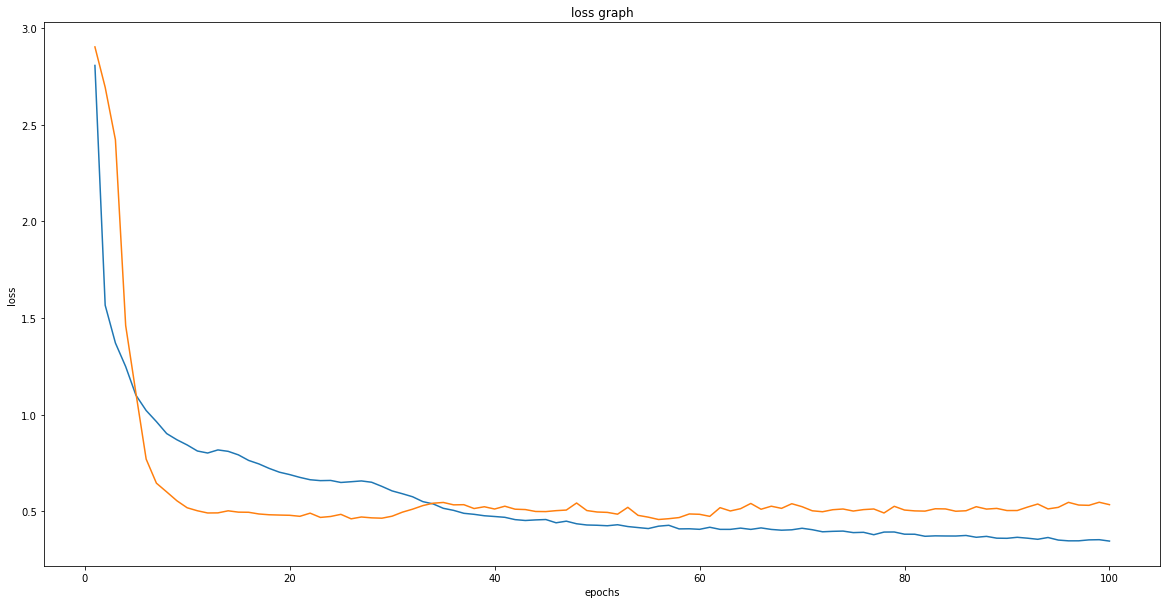

1 tensor(2.8075, grad_fn=<MeanBackward0>)


In [13]:
plt.figure(figsize=(20,10))
plt.plot(range(1,epochs+1), mean_losses_train)
plt.plot(range(1,epochs+1), mean_losses_valid)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss graph')
plt.show()
max_y = max(mean_losses_train)  # Find the maximum y value
max_x = range(1,epochs+1)[mean_losses_train.index(max_y)]  # Find the x value corresponding to the maximum y value
print(max_x, max_y)